# Set-up environment

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Load data

In [3]:
df = pd.concat(
    [pd.read_csv(f) for f in glob.glob("../Data/*.csv")], 
    ignore_index=True
)
df.sample()

,title,address,price,area,noithat,gac,kebep,maylanh,maygiat,tulanh,thangmay,chungchu,giotu,hamxe,ngaydang,thongtinmota,url
14664,CĂN HỘ FULL NỘI THẤT THOÁNG MÁT GẦN SÂN BAY TÂ...,"Đường Yên Thế, Phường 2, Quận Tân Bình, Hồ Chí...",6.3 triệu/tháng,30 m2,0,0,0,0,0,0,0,0,0,0,"Thứ 4, 09:52 09/10/2024","Gần Sân Bay Tân Sơn Nhất, CV Hoàng Văn Thụ, CV...",https://phongtro123.com/can-ho-full-noi-that-t...


# I. Dataset Overview


## 1. Basic Information

In [4]:
num_rows, num_cols = df.shape
size = num_rows * num_cols

print(f'Số hàng: {num_rows}')
print(f'Số cột: {num_cols}')
print(f'Overall size: {size}')
print('Mỗi dòng đại diện: Thông tin cho thuê phòng trọ')

Số hàng: 24121
Số cột: 17
Overall size: 410057
Mỗi dòng đại diện: Thông tin cho thuê phòng trọ


In [5]:
duplicate = df.duplicated().sum()
rows_empty = df.isnull().all(axis = 1).sum()
print(f'Số dòng trùng: {duplicate}')
print(f'Số dòng trống: {rows_empty}')

Số dòng trùng: 135
Số dòng trống: 0


Có thể do bị đăng lại nhiều lần hoặc do có dữ liệu mới đẩy bài đăng xuống khiến cho bị trùng khi thu thập dữ liệu do đó ta sẽ xóa bớt các dòng trùng

In [6]:
df = df.drop_duplicates()

## 2. Column Inventory


### Column Definitions

| Column | Definition |
| :--- | :--- |
| **title** | Tiêu đề bài đăng cho thuê. |
| **address** | Địa chỉ chi tiết của bất động sản. |
| **price** | Giá cho thuê (VNĐ/Tháng). |
| **area** | Diện tích sử dụng ($m^2$). |
| **ngaydang** | Ngày đăng tin. |
| **thongtinmota**| Mô tả chi tiết thêm (chứa thông tin ẩn). |
| **url** | Đường dẫn gốc tới bài đăng. |
| **noithat** | Có đầy đủ nội thất không? (0: Không, 1: Có) |
| **gac** | Có gác lửng không? (0: Không, 1: Có) |
| **kebep** | Có kệ bếp không? (0: Không, 1: Có) |
| **maylanh** | Có máy lạnh không? (0: Không, 1: Có) |
| **maygiat** | Có máy giặt không? (0: Không, 1: Có) |
| **tulanh** | Có tủ lạnh không? (0: Không, 1: Có) |
| **thangmay** | Có thang máy không? (0: Không, 1: Có) |
| **chungchu** | Ở chung chủ hay không? (0: Không, 1: Có) |
| **hamxe** | Có hầm để xe không? (0: Không, 1: Có) |
| **giotu** | Giờ giấc tự do/không giới nghiêm? (0: Không, 1: Có) |

### Which columns are relevant to potential analysis?

Để xây dựng mô hình dự đoán giá nhà, các cột được phân loại theo mức độ quan trọng như sau:

* **Target Variable (Biến mục tiêu):**
    * `price`: Giá trị cần dự đoán.

* **Input Features (Biến đặc trưng):**
    * **Nhóm quan trọng nhất:** `area` và `address`. Đây là hai yếu tố quyết định giá cả.
    * **Nhóm tiện ích:** `noithat`, `maylanh`, `thangmay`, `gac`... Các biến này ảnh hưởng đến phân khúc giá (Cao cấp vs Bình dân).

###  Are there any columns that should be dropped?


| Column | Action | Reason & Solution |
| :--- | :--- | :--- |
| **url** | **Drop (Xóa)** | **Lý do:** Đây là dữ liệu kỹ thuật, không chứa thông tin về đặc điểm căn nhà.<br>**Giải pháp:** Xóa khi chạy mô hình (chỉ giữ lại nếu cần debug). |
| **title** & **thongtinmota** | **Process/Drop** | **Lý do:** Dữ liệu dạng văn bản tự do, khó đưa vào mô hình.<br>**Giải pháp:** Tách thông tin (ví dụ: tìm từ khóa liên quan đến tiện ích "nội thất", "wifi") rồi mới xóa cột gốc. |
| **address** | **Process (Xử lý)** | **Lý do:** Địa chỉ cụ thể có quá nhiều giá trị duy nhất .<br>**Giải pháp:** Sử dụng kỹ thuật **Embedding** (ví dụ: TF-IDF, Word2Vec,...) để chuyển đổi địa chỉ thành vector đặc trưng trước khi đưa vào mô hình. |

## 3. Data Types

In [7]:
df.dtypes

title           object
address         object
price           object
area            object
noithat          int64
gac              int64
kebep            int64
maylanh          int64
maygiat          int64
tulanh           int64
thangmay         int64
chungchu         int64
giotu            int64
hamxe            int64
ngaydang        object
thongtinmota    object
url             object
dtype: object

### What is the current data type of each column?

Dựa trên kết quả kiểm tra `df.dtypes`, dữ liệu hiện tại được phân loại như sau:

* **Object:** `title`, `address`, `price`, `area`, `ngaydang`, `thongtinmota`, `url`.
* **Int64:** `noithat`, `gac`, `kebep`, `maylanh`, `maygiat`, `tulanh`, `thangmay`, `chungchu`, `giotu`, `hamxe`.

### Are there columns with inappropriate data types?

**Có.** Một số cột mang ý nghĩa định lượng (số liệu) hoặc thời gian nhưng hiện tại đang được lưu dưới dạng `object` (chuỗi ký tự). Điều này sẽ ngăn cản việc thực hiện các phép tính toán học (tính trung bình, tổng) hoặc phân tích chuỗi thời gian.

Cụ thể các cột chưa phù hợp:
* `price` (Giá tiền)
* `area` (Diện tích)
* `ngaydang` (Thời gian)

### Which columns need type conversion?

| Cột (Column) | Kiểu hiện tại | Kiểu mong muốn | Lý do  |
| :--- | :---: | :---: | :--- |
| **price** | `object` | `float` | **Lý do:** Cần dạng số thực để tính toán giá trung bình, giá cao nhất/thấp nhất.|
| **area** | `object` | `float` | **Lý do:** Cần dạng số thực để tính toán diện tích và đơn giá ($Price/m^2$) |
| **ngaydang** | `object` | `datetime` | **Lý do:** Cần dạng thời gian để trích xuất ngày, tháng, năm để có thể phân tích xu hướng.|

Dưới đây là bước tiền xử lí trước khi ta phân tích tiếp

In [8]:
df_process = df.copy()
s = df_process['price'].astype(str)
dong_val = s.str.extract(r'([\d\.]+)\s*đồng')[0]
dong_val = pd.to_numeric(dong_val.str.replace('.', ''), errors='coerce')
dong_val = dong_val / 1000000
trieu_val = s.str.extract(r'([\d\.]+)\s*triệu')[0]
trieu_val = pd.to_numeric(trieu_val, errors='coerce')

df_process['price'] = pd.to_numeric(df_process['price'], errors='coerce')
df_process['price'] = df_process['price'].fillna(dong_val)
df_process['price'] = df_process['price'].fillna(trieu_val)

df_process['area'] = df_process['area'].astype(str).str.replace('m2','')
df_process['area'] = pd.to_numeric(df_process['area'], errors='coerce')

df_process['ngaydang'] = df_process['ngaydang'].astype(str).str.extract(r'(\d{2}/\d{2}/\d{4})')
df_process['ngaydang'] = pd.to_datetime(df_process['ngaydang'], format='%d/%m/%Y', errors='coerce')

df_process['thang'] = df_process['ngaydang'].dt.month


# II. Numerical Columns Analysis

,Column,Mean,Median,Std,Skew,Shape,Min,Max,Lower Bound,Upper Bound,Outliers Count,Percentage outliers,Missing (%),Impossible (<=0),Placeholders
0,price,3.79,3.8,2.30,59.50,Lệch phải,0.000001,260.000025,0.35,7.15,330,1.38%,0.08%,0,None
1,area,28.07,25.0,17.33,15.91,Lệch phải,0.000000,1000.000000,5.00,45.00,831,3.46%,0.03%,13,0


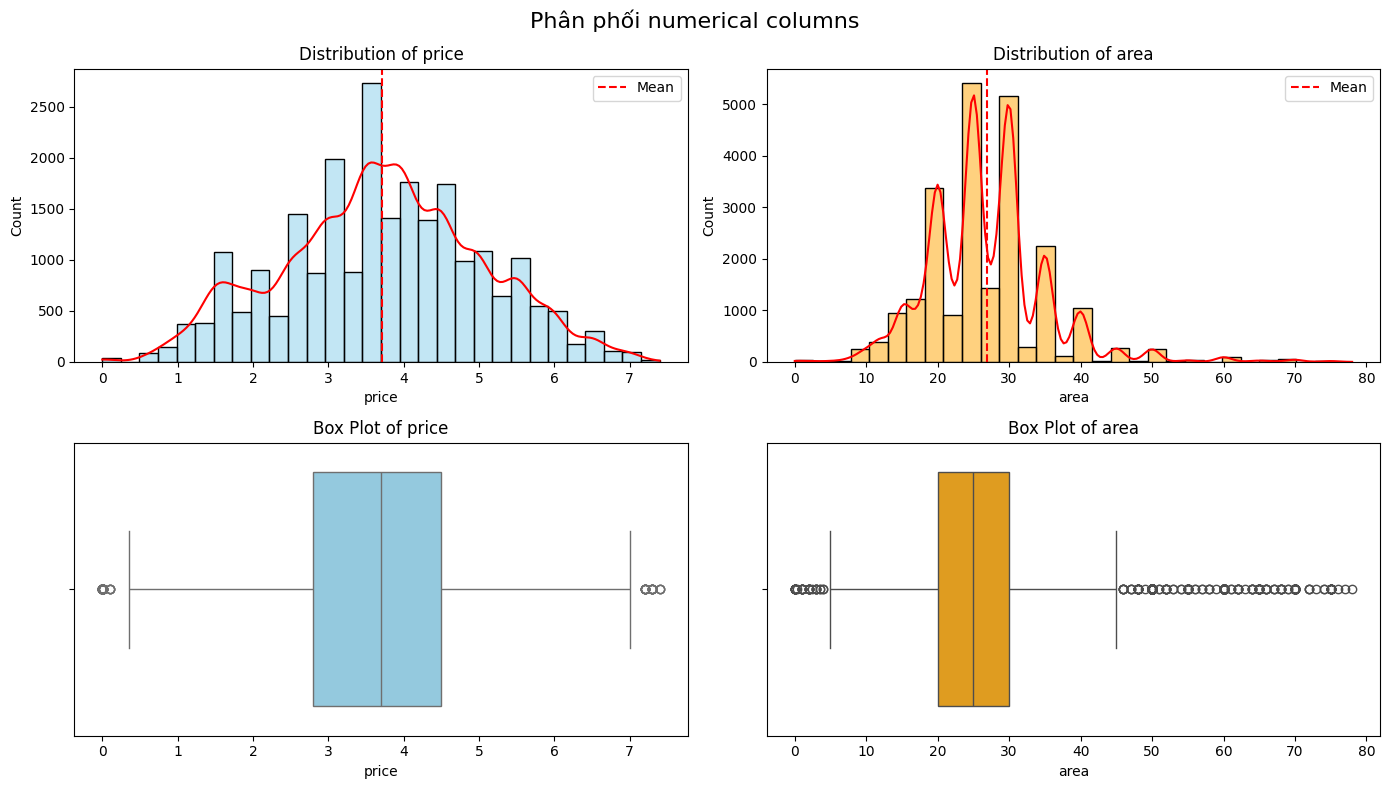

In [15]:
numerical_cols = ['price','area']
summary = []
for name_col in numerical_cols:
    col = df_process[name_col]
    mean_val = round(col.mean(),2)
    median_val = round(col.median(),2)
    std_val = round(col.std(),2)
    skew_val = round(col.skew(),2)
    if skew_val > 1: 
        shape = "Lệch phải"
    elif skew_val < -1: 
        shape = "Lệch trái"
    else: 
        shape = "Đối xứng"

    min_val = col.min()
    max_val = col.max()
    
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_process[(col < lower_bound) | (col > upper_bound)]
    num_outliers = len(outliers)
    percent_outliers = num_outliers / len(df_process) * 100

    num_missing = col.isnull().sum()
    pct_missing = num_missing/len(df_process) * 100.0 
    num_impossible = (col <= 0).sum()
    placeholders_found = []
    for p_val in [0, -1, 999]:
        if (col == p_val).any():
            placeholders_found.append(str(p_val))
    
    placeholder_note = ", ".join(placeholders_found) if placeholders_found else "None"
    summary.append({
        "Column": name_col,
        "Mean": mean_val,
        "Median": median_val,
        "Std": std_val,
        "Skew": skew_val,
        "Shape": shape,
        "Min": min_val,
        "Max": max_val,
        "Lower Bound": round(lower_bound, 2),
        "Upper Bound": round(upper_bound, 2),
        "Outliers Count": num_outliers,
        "Percentage outliers": f"{percent_outliers:.2f}%",
        "Missing (%)": f"{pct_missing:.2f}%",
        "Impossible (<=0)": num_impossible,
        "Placeholders": placeholder_note,
    })
summary_df = pd.DataFrame(summary)
display(summary_df)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
fig.suptitle('Phân phối numerical columns', fontsize=16)

colors = ['skyblue', 'orange']

for i, col in enumerate(numerical_cols):
    data_viz = df_process[df_process[col] < df_process[col].quantile(0.99)][col] 
    sns.histplot(data_viz, kde=True, ax=axes[0, i], color=colors[i], bins=30)
    axes[0, i].lines[-1].set_color('red')
    axes[0, i].set_title(f'Distribution of {col}')
    axes[0, i].axvline(data_viz.mean(), color='red', linestyle='--', label='Mean')
    axes[0, i].legend()

    sns.boxplot(x=data_viz, ax=axes[1, i], color=colors[i])
    axes[1, i].set_title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()



## 1. Distribution & Central Tendency
* **Distribution Shape:**
    * **Price:** Phân phối lệch phải nặng (Right-skewed, Skew $\approx$ 59.5).
    * **Area:** Phân phối lệch phải (Right-skewed, Skew $\approx$ 15.9) và đa đỉnh  tại các mốc chẵn (20, 25, 30 $m^2$).
* **Central Tendency:**
    * **Price:** Mean (3.79 triệu) $\approx$ Median (3.8 triệu). Mức giá phổ biến quanh 3.8 triệu.
    * **Area:** Mean (28.1 $m^2$) > Median (25 $m^2$), do bị kéo bởi các bất động sản diện tích lớn.

## 2. Range & Outliers
* **Range:**
    * **Price:** 0 - 260 triệu. Min $\approx$ 0 là lỗi.
    * **Area:** 0 - 1000 $m^2$. Min = 0 là lỗi.
* **Outliers:** Tồn tại nhiều giá trị ngoại lai.
    * Giá trị cao (Price > 7.15 tr, Area > 45 $m^2$) là **Genuine** (phân khúc cao cấp/nguyên căn).
    * Giá trị xấp xỉ 0 là **Errors** (lỗi nhập liệu).

## 3. Data Quality
* **Missing Values:** Rất thấp (Price: 0.08%, Area: 0.03%).
* **Impossible Values:** Phát hiện **13 dòng** Area $\le 0$ và một số dòng Price $\approx 0$.
* **Placeholders:** Số 0 được dùng làm placeholder cho dữ liệu thiếu.

Đối với các missing thì đa số là do bị lỗi request còn với các giá trị bất thường thì có thể do người bán nhập sai ta sẽ tiến hành xóa các missing và xóa bớt các giá trị bất thường.

In [ ]:
df_process = df_process[
    (df_process['area'] > 1) &(df_process['area'] <50) & (df_process['price'] < 20)&
    (df_process['price'] > 0.1) 
].dropna(subset=['price', 'area'])
print(f'Sau khi xóa dữ liệu còn {df_process.shape[0]} hàng')

Sau khi xóa dữ liệu còn 23125 hàng
